# Data



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([transforms.ToTensor()])

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15061671.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489999.41it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4409677.59it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9922150.40it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [4]:
train_size = 50000
val_size = 10000
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

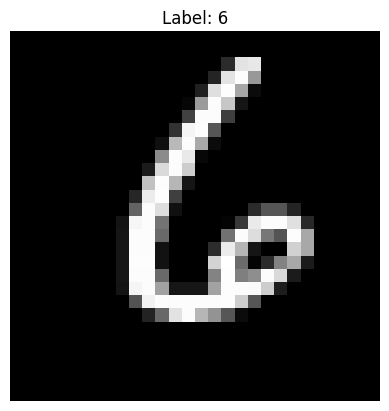

In [5]:
import matplotlib.pyplot as plt
import torchvision
import torch

def denormalize(tensor):
    tensor = tensor * 0.5
    return tensor

image, label = train_dataset[0]

image = denormalize(image)

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


# MODEL

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time


# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1,padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1,padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=32*7*7, out_features=500),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, input_):
        out = self.conv_layer1(input_)
        out = self.conv_layer2(out)
        out = out.reshape(out.size(0), -1)  # Flatten the output
        out = self.fc1(out)
        out = self.fc2(out)
        return out



In [7]:
# Function to plot loss and accuracy
def plot_loss(train_error, test_error, accuracy, steps=200):
    x = steps * np.arange(0, len(train_error))
    plt.rcParams["figure.figsize"] = (18,6)
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(x, train_error, label='Train Error')
    ax1.plot(x, test_error, label='Val Error')
    ax1.set_title('Error Plot')
    ax1.set(xlabel='Iterations', ylabel='Average Error')
    ax1.legend(loc='upper left')
    ax1.grid()

    ax2.plot(x, accuracy, label='Accuracy')
    ax2.set_title('Model Val Accuracy')
    ax2.set(xlabel='Iterations', ylabel='Accuracy')
    ax2.grid()
    plt.show()

# Function to visualize predictions
def plot_images(show_images, show_labels, model):
    model.eval()
    pred = model(show_images.to(device))
    pred_labels = torch.max(pred, 1)[1].cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    columns = 3
    rows = 1
    for i in range(1, columns * rows + 1):
        fig.add_subplot(rows, columns, i)
        true_val = show_labels[i-1].data.cpu().numpy()
        pred_val = pred_labels[i-1]
        a = 'True: ' + str(true_val) + ' Pred: ' + str(pred_val)
        plt.title(a)
        plt.axis('off')
        plt.imshow(show_images[i-1].cpu().reshape(-1, 28), cmap='gray')
    plt.show()

# TRAINING

In [9]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
model = CNN().to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
cost_train, cost_val, acc_val = [], [], []
total_steps = len(train_loader)
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        running_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            avg_train_loss = running_train_loss / (i+1)
            print(f'Epoch: [{epoch+1}/{NUM_EPOCHS}], Step: {i+1}/{total_steps}, Training Loss: {avg_train_loss:.6f}')

            model.eval()
            with torch.no_grad():
                correct, total, val_loss_sum = 0, 0, 0.0
                for val_images, val_labels in val_loader:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)

                    preds = model(val_images)
                    val_loss = criterion(preds, val_labels)
                    val_loss_sum += val_loss.item()

                    _, predicted = torch.max(preds.data, 1)
                    total += val_labels.size(0)
                    correct += (predicted == val_labels).sum().item()

                avg_val_loss = val_loss_sum / len(val_loader)
                val_accuracy = correct / total
                print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

                cost_train.append(avg_train_loss)
                cost_val.append(avg_val_loss)
                acc_val.append(val_accuracy)

            model.train()

print(f'Training finished, took {time.time() - training_start_time:.2f}s')


Epoch: [1/10], Step: 200/782, Training Loss: 0.442227
Validation Loss: 0.1865, Validation Accuracy: 0.9429
Epoch: [1/10], Step: 400/782, Training Loss: 0.280133
Validation Loss: 0.0943, Validation Accuracy: 0.9709
Epoch: [1/10], Step: 600/782, Training Loss: 0.217945
Validation Loss: 0.0752, Validation Accuracy: 0.9760
Epoch: [2/10], Step: 200/782, Training Loss: 0.059294
Validation Loss: 0.0599, Validation Accuracy: 0.9825
Epoch: [2/10], Step: 400/782, Training Loss: 0.055452
Validation Loss: 0.0598, Validation Accuracy: 0.9825
Epoch: [2/10], Step: 600/782, Training Loss: 0.055183
Validation Loss: 0.0529, Validation Accuracy: 0.9842
Epoch: [3/10], Step: 200/782, Training Loss: 0.033074
Validation Loss: 0.0685, Validation Accuracy: 0.9812
Epoch: [3/10], Step: 400/782, Training Loss: 0.035039
Validation Loss: 0.0466, Validation Accuracy: 0.9871
Epoch: [3/10], Step: 600/782, Training Loss: 0.034638
Validation Loss: 0.0439, Validation Accuracy: 0.9881
Epoch: [4/10], Step: 200/782, Trainin

In [14]:
torch.save(model.state_dict(), 'model.ckpt')



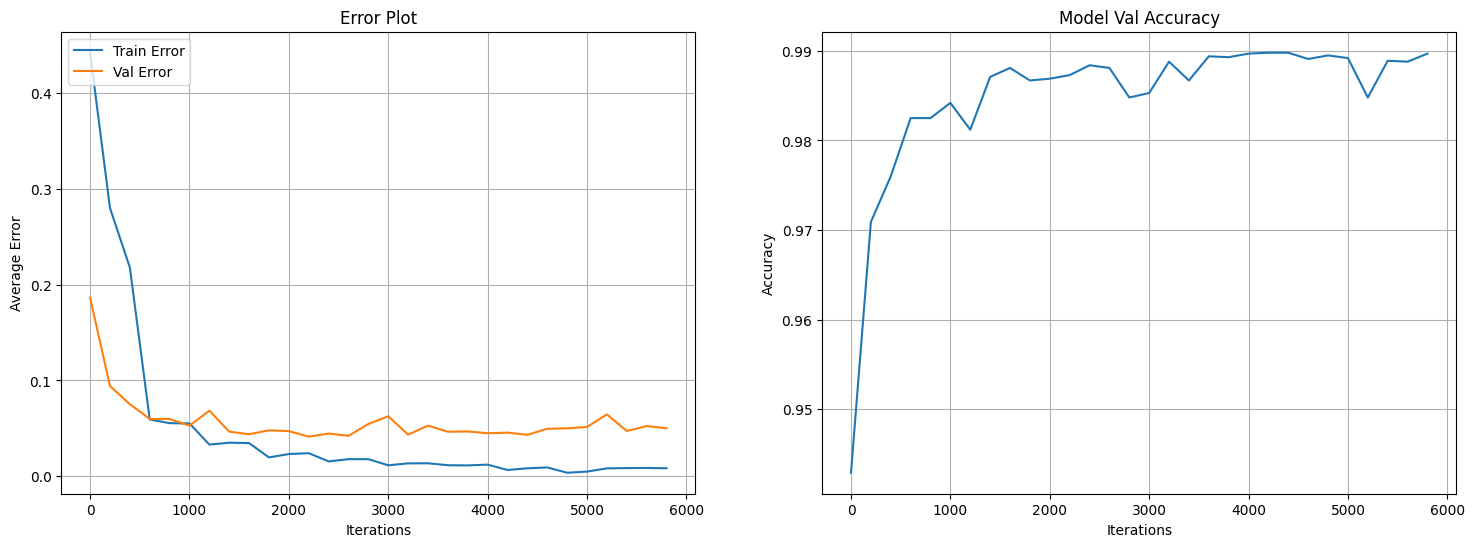

In [15]:
plot_loss(cost_train, cost_val, acc_val, steps=200)

In [16]:
model.eval()
with torch.no_grad():
    correct, total, test_loss_sum = 0, 0, 0.0
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_preds = model(test_images)
        test_loss = criterion(test_preds, test_labels)
        test_loss_sum += test_loss.item()

        _, predicted = torch.max(test_preds.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

    avg_test_loss = test_loss_sum / len(test_loader)
    test_accuracy = correct / total
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0345, Test Accuracy: 0.9916


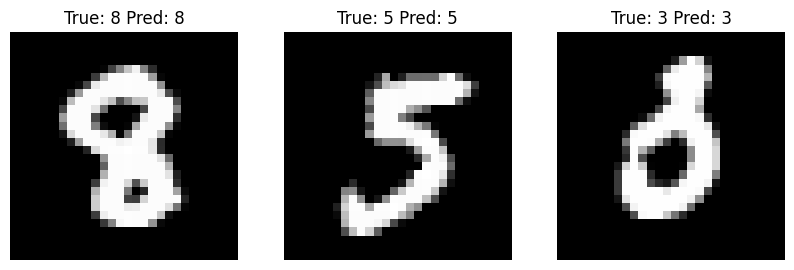

In [17]:
# Visualize
plot_images(images[:3], labels[:3], model)

3. Report the dimensions of the input and output at each layer.

4. How many parameters does your network have? How many of thes are in the fully connected layers and how many are in the convolutional layers?

<font color="green">Answer:</font>


| Layer Type          | Output Shape              | Parameters      |
|---------------------|---------------------------|------------------|
| Input               | (Batch Size, 1, 28, 28)   | 0                |
| Conv Layer 1        | (Batch Size, 32, 28, 28)  | 320              |
| ReLU                | (Batch Size, 32, 28, 28)  | 0                |
| Max Pooling 1       | (Batch Size, 32, 14, 14)  | 0                |
| Conv Layer 2        | (Batch Size, 32, 14, 14)  | 9,248            |
| ReLU                | (Batch Size, 32, 14, 14)  | 0                |
| Max Pooling 2       | (Batch Size, 32, 7, 7)    | 0                |
| Flatten             | (Batch Size, 1, 568)      | 0                |
| FC Layer 1          | (Batch Size, 500)         | 784,500          |
| ReLU                | (Batch Size, 500)         | 0                |
| FC Layer 2          | (Batch Size, 10)          | 5,010            |
| **Total Parameters** |                           | **799,078**      |
| **Conv Parameters**  |                           | **9,568**        |
| **FC Parameters**    |                           | **789,510**      |


### Parameters:
(
1
×
3
×
3
+
1
)
×
32
=
320
(1×3×3+1)×32=320

Output Shape: (Batch Size, 32, 14, 14)
Parameters:
(
32
×
3
×
3
+
1
)
×
32
=
9
,
248
(32×3×3+1)×32=9,248

Parameters:
(
32
×
7
×
7
+
1
)
×
500
=
784
,
500
(32×7×7+1)×500=784,500

Parameters:
(
500
+
1
)
×
10
=
5
,
010
(500+1)×10=5,010


5. How many neurons does your network have? How many of these are in the fully connected layers and how many are in the convolutional layers?


<font color='green'>Answer: </font>


Total Conv Neurons =
25
,
088
+
6
,
272
=
31
,
360
25,088+6,272=31,360
Fully Connected Layers:

Total FC Neurons =
500
+
10
=
510
500+10=510
Total Neurons in the Network:

Total Neurons =
31
,
360
+
510
=
31
,
870


# USING BATCH NORM

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=32*7*7, out_features=500),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=500, out_features=10)

    def forward(self, input_):
        out = self.conv_layer1(input_)
        out = self.conv_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [19]:
model_bn = CNN_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bn.parameters(), lr=LEARNING_RATE)

In [20]:
total_steps = len(train_loader)
cost_train_bn, cost_val_bn, acc_train_bn, acc_val_bn = [], [], [], []
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_bn(images)
        loss = criterion(outputs, labels)
        running_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 200 == 0:
            avg_train_loss = running_train_loss / (i + 1)
            train_accuracy = correct_train / total_train
            print('Epoch:[{}/{}], Step:{}/{}, Train Loss: {:.6f}, Train Accuracy: {:.4f}'.format(
                epoch + 1, NUM_EPOCHS, i + 1, total_steps, avg_train_loss, train_accuracy))

            model_bn.eval()
            running_val_loss = 0.0
            correct_val, total_val = 0, 0

            with torch.no_grad():
                for val_images, val_labels in val_loader:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)

                    preds = model_bn(val_images)
                    val_loss = criterion(preds, val_labels)
                    running_val_loss += val_loss.item()

                    _, predicted = torch.max(preds.data, 1)
                    total_val += val_labels.size(0)
                    correct_val += (predicted == val_labels).sum().item()

            avg_val_loss = running_val_loss / len(val_loader)
            val_accuracy = correct_val / total_val
            print('Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(avg_val_loss, val_accuracy))

            cost_train_bn.append(avg_train_loss)
            cost_val_bn.append(avg_val_loss)
            acc_train_bn.append(train_accuracy)
            acc_val_bn.append(val_accuracy)

            model_bn.train()


print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch:[1/10], Step:200/782, Train Loss: 0.201017, Train Accuracy: 0.9338
Validation Loss: 0.0880, Validation Accuracy: 0.9714
Epoch:[1/10], Step:400/782, Train Loss: 0.136473, Train Accuracy: 0.9556
Validation Loss: 0.0648, Validation Accuracy: 0.9811
Epoch:[1/10], Step:600/782, Train Loss: 0.111094, Train Accuracy: 0.9647
Validation Loss: 0.0711, Validation Accuracy: 0.9812
Epoch:[2/10], Step:200/782, Train Loss: 0.036058, Train Accuracy: 0.9887
Validation Loss: 0.0736, Validation Accuracy: 0.9805
Epoch:[2/10], Step:400/782, Train Loss: 0.035941, Train Accuracy: 0.9890
Validation Loss: 0.0527, Validation Accuracy: 0.9859
Epoch:[2/10], Step:600/782, Train Loss: 0.037093, Train Accuracy: 0.9884
Validation Loss: 0.0485, Validation Accuracy: 0.9871
Epoch:[3/10], Step:200/782, Train Loss: 0.017443, Train Accuracy: 0.9941
Validation Loss: 0.0566, Validation Accuracy: 0.9856
Epoch:[3/10], Step:400/782, Train Loss: 0.019927, Train Accuracy: 0.9933
Validation Loss: 0.0591, Validation Accuracy:

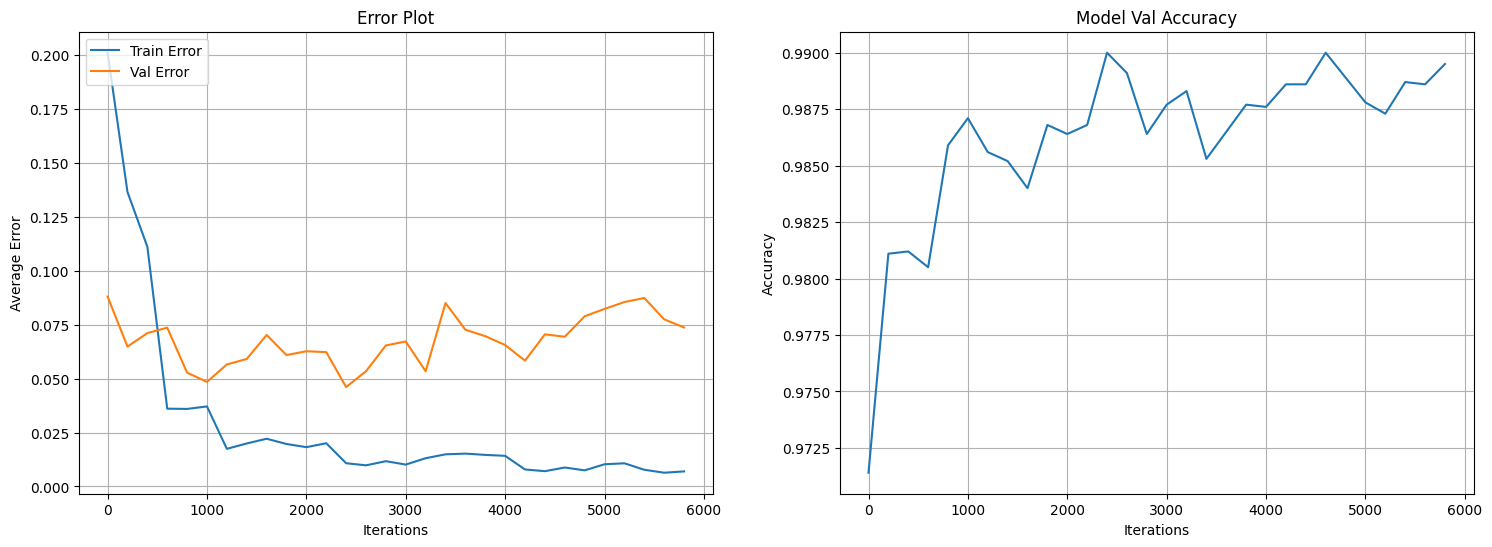

In [21]:
torch.save(model_bn.state_dict(), 'model_bn.ckpt')

plot_loss(cost_train_bn, cost_val_bn, acc_val_bn, steps=200)

In [22]:
model_bn.eval()
with torch.no_grad():
    correct_test, total_test, running_test_loss = 0, 0, 0.0
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_preds = model_bn(test_images)
        test_loss = criterion(test_preds, test_labels)
        running_test_loss += test_loss.item()

        _, predicted = torch.max(test_preds.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    print('Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(avg_test_loss, test_accuracy))


Test Loss: 0.0562, Test Accuracy: 0.9912


<font color='green'> The model **after** batch normalisation takes more time (112.62s) to train and has test accuracy of 99.12%

The model **before** batch normalisation takes lesser time (110.71) to train and has test accuracy of 99.16% .</font>

# 2 Visualizing Convolutional Neural Network :

## 1. Plot the Conv1 Layer Filters

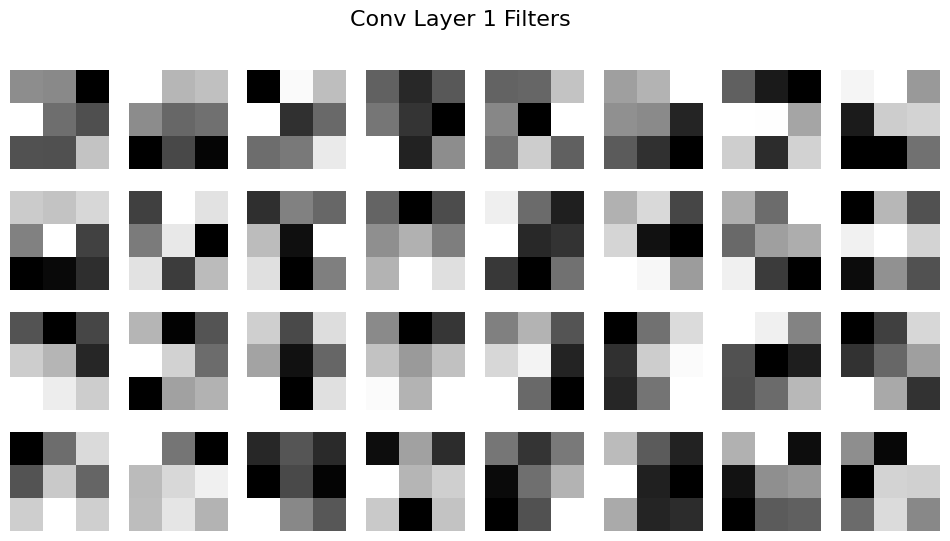

In [23]:
import matplotlib.pyplot as plt

def plot_conv_filters(model, layer_name, n_filters=32):
    filters = model.conv_layer1[0].weight.data.cpu().numpy()  #Get the weights of the first conv layer
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))

    for i in range(n_filters):
        ax = axes[i // 8, i % 8]
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Conv Layer 1 Filters', fontsize=16)
    plt.show()

#Call the function to plot filters
plot_conv_filters(model, 'conv_layer1')


## Plot Filters of a Higher Layer (Conv2)

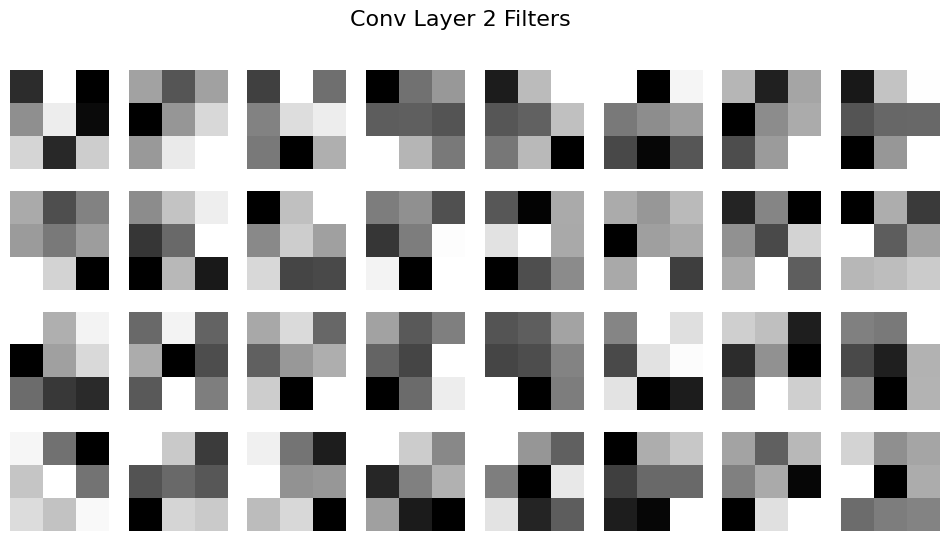

In [24]:
def plot_conv_filters_high(model, layer_name, n_filters=32):
    filters = model.conv_layer2[0].weight.data.cpu().numpy()  #Get the weights of the second conv layer
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))

    for i in range(n_filters):
        ax = axes[i // 8, i % 8]
        ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')
    plt.suptitle(f'Conv Layer 2 Filters', fontsize=16)
    plt.show()

#Call the function to plot filters
plot_conv_filters_high(model, 'conv_layer2')


## Visualize the Activations of the Convolutional Layers

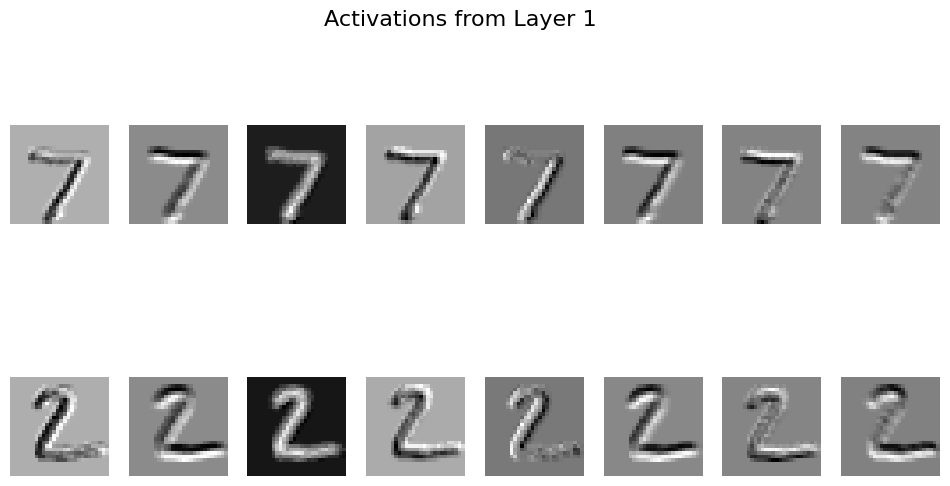

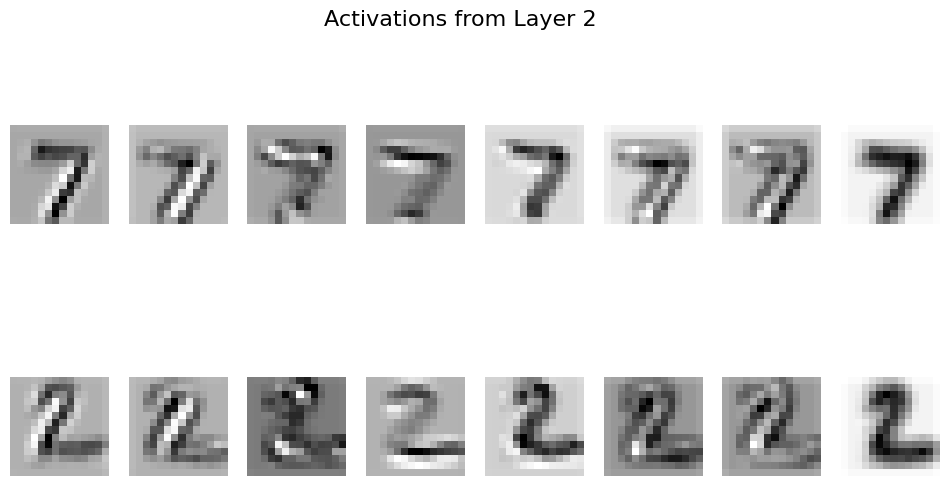

In [25]:
# Define hooks to capture activations
activations = []

def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

#Register hooks
hook1 = model.conv_layer1[0].register_forward_hook(get_activation('conv_layer1'))
hook2 = model.conv_layer2[0].register_forward_hook(get_activation('conv_layer2'))

#Get a sample image from the test set
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

#Forward pass
_ = model(images)

#Plot activations
def plot_activations(activations, layer_idx, n_filters=8):
    act = activations[layer_idx].data.cpu().numpy()
    fig, axes = plt.subplots(2, n_filters, figsize=(12, 6))

    for i in range(n_filters):
        ax = axes[0, i]
        ax.imshow(act[0, i, :, :], cmap='gray')  # Plotting the first image in the batch
        ax.axis('off')

        ax = axes[1, i]
        ax.imshow(act[1, i, :, :], cmap='gray')  # Plotting the second image in the batch
        ax.axis('off')

    plt.suptitle(f'Activations from Layer {layer_idx + 1}', fontsize=16)
    plt.show()

# Call the function to plot activations for both layers
plot_activations(activations, 0, n_filters=8)  # Conv Layer 1
plot_activations(activations, 1, n_filters=8)  # Conv Layer 2

# Remove hooks
hook1.remove()
hook2.remove()


## OCCLUSION

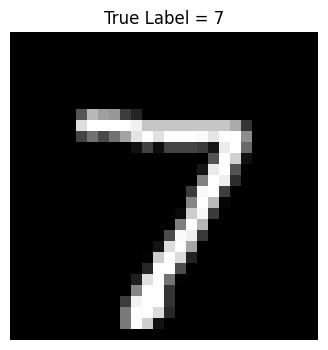

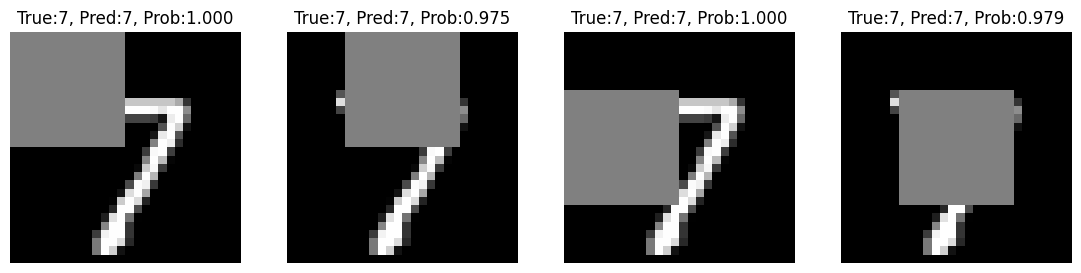

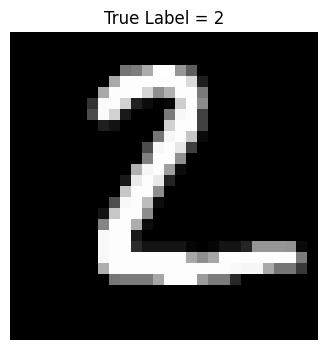

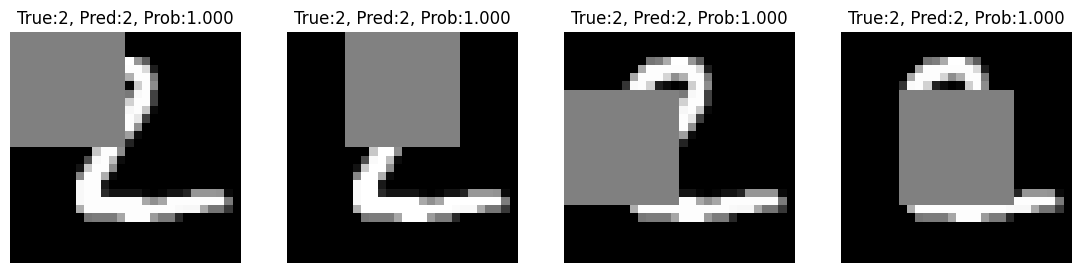

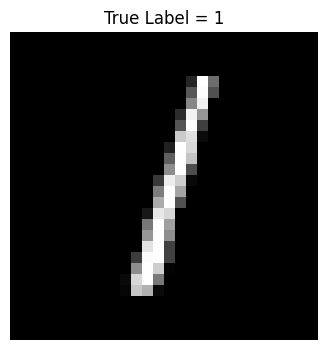

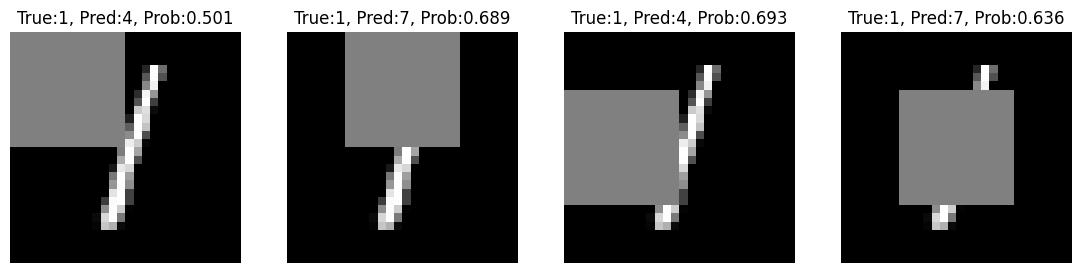

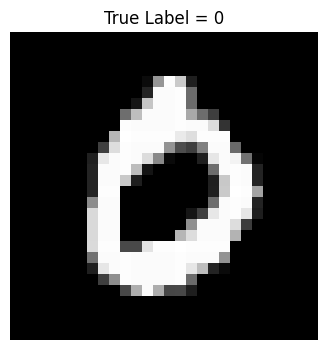

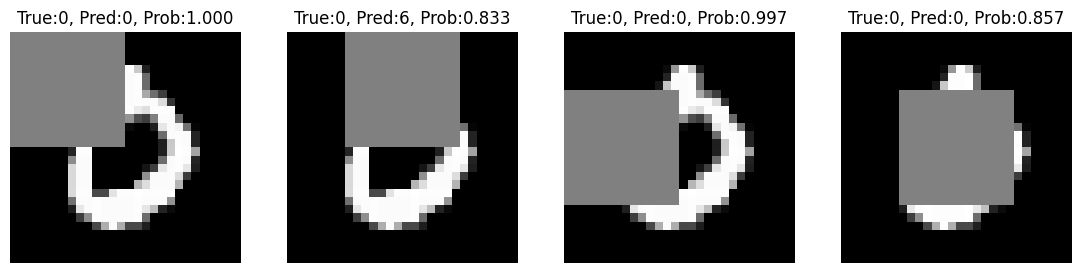

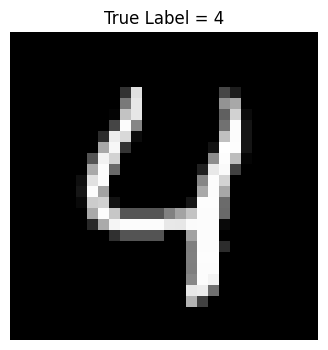

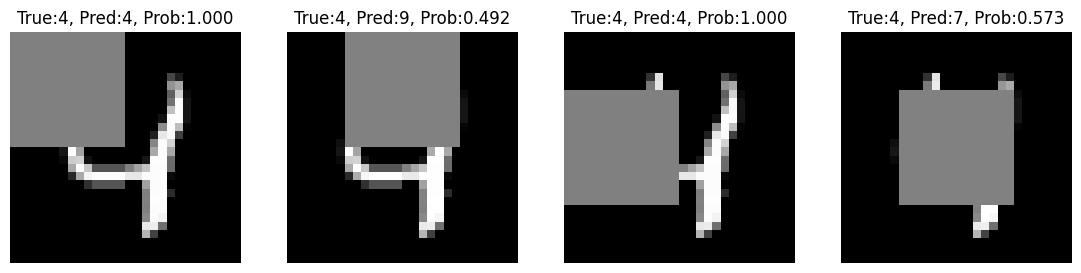

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to occlude parts of the image
def occluded_image(input_image, location, patch_size=14):  # Increased patch size
    input_image_copy = input_image.copy()
    x = int(location[0])
    y = int(location[1])
    input_image_copy[x:x + patch_size, y:y + patch_size] = 0.5  # Gray out the occluded patch
    return input_image_copy

# Loop through the test set
for img, label in test_loader:
    img_5_g = img[:5].to(device)  # Take the first 5 images
    label_5_g = label[:5].to(device)

    for i in range(5):
        img_1_c = img_5_g[i].cpu().numpy().reshape(28, 28)  # Reshape to 28x28 for visualization

        # Show the original image
        plt.figure(figsize=(4, 4))
        plt.axis("off")
        plt.title("True Label = " + str(np.squeeze(label.data.cpu().numpy())[i]))
        plt.imshow(img_1_c, cmap='gray')
        plt.show()

        # Create a figure for occluded images
        fig = plt.figure(figsize=(28, 8))

        row, col = 2, 8
        loc = []

        # Generate locations for occlusion (every 7 pixels)
        for x in range(0, 28 - 14, 7):  # Adjust for larger patch size
            for y in range(0, 28 - 14, 7):  # Adjust for larger patch size
                loc.append([x, y])

        # Loop through each location for occlusion
        for j in range(len(loc)):
            a = fig.add_subplot(row, col, j + 1)
            occ_1_img = occluded_image(img_1_c, loc[j], patch_size=14)  # Use larger occlusion
            plt.imshow(occ_1_img, cmap='gray')
            plt.axis("off")

            # Convert the occluded image to a tensor and move to device
            img_1_torch = torch.from_numpy(occ_1_img.reshape(1, 1, 28, 28)).to(device)
            prediction_vect_gpu = model(img_1_torch)  # Get predictions
            prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()
            prediction_vect_cpu = np.squeeze(prediction_vect_cpu)

            # Calculate probabilities
            prediction_prob_vect = np.exp(prediction_vect_cpu) / np.sum(np.exp(prediction_vect_cpu))
            predicted_digit = np.argmax(prediction_prob_vect)
            prediction_probability = prediction_prob_vect[predicted_digit]

            # Set title for the subplot with true and predicted values
            a.set_title('True:{}, Pred:{}, Prob:{:.3f}'.format(label.data[i].item(), predicted_digit, prediction_probability))

        plt.show()  # Show all occluded images with predictions
    break  # Remove this break if you want to see more than one batch


<font color='green'>As can be seen from above results, As we occlude the digit image, the probability of the actual prediction image drops, and sometimes the model prediction goes wrong, which shows that our model is actually looking at the meaningful features for digit classification.

# NON TARGETED ATTACK

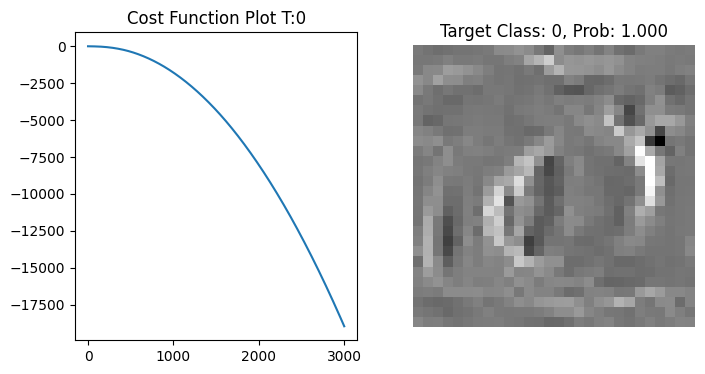

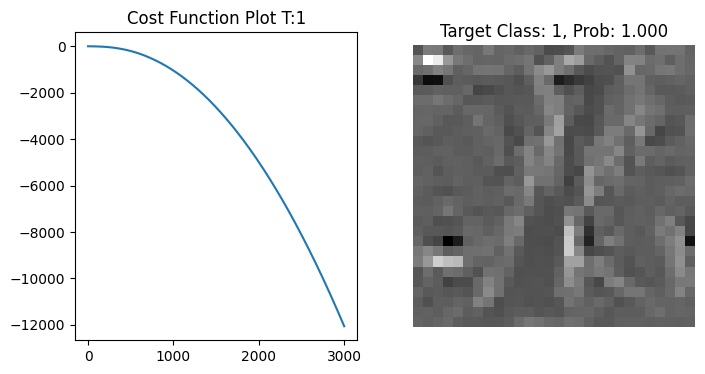

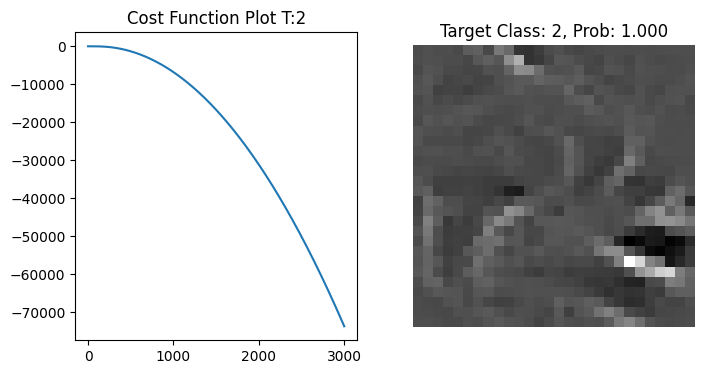

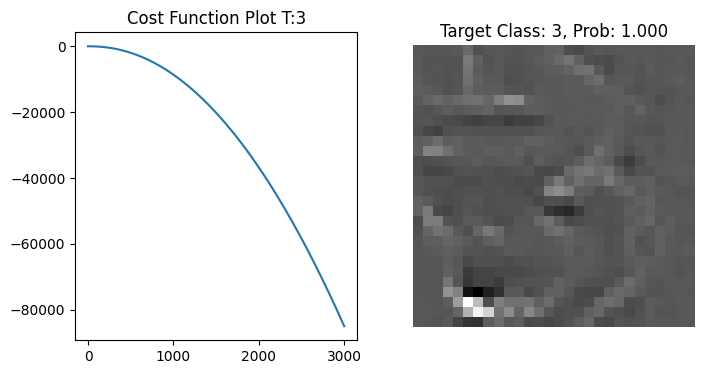

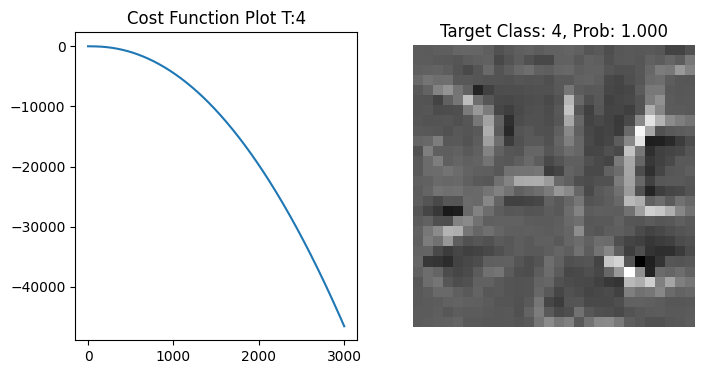

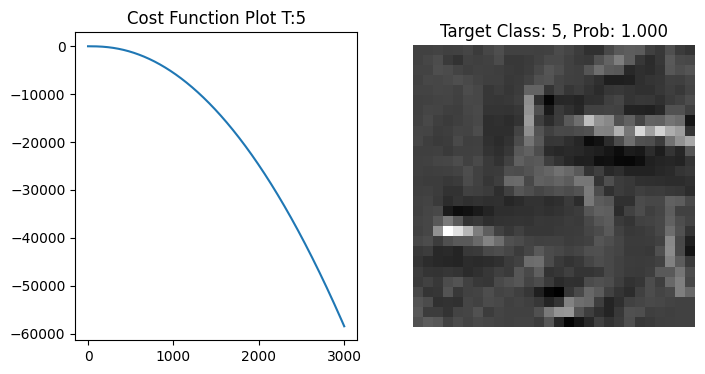

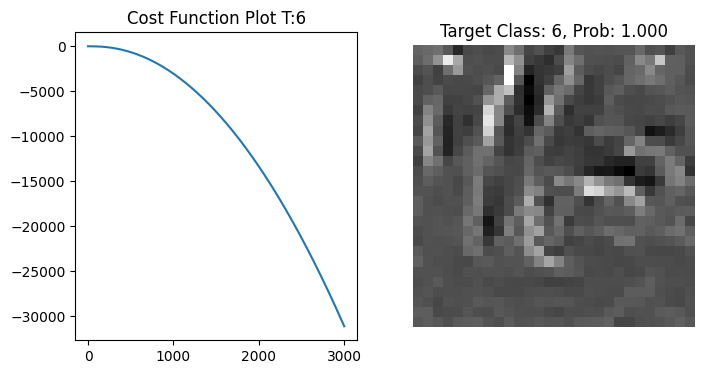

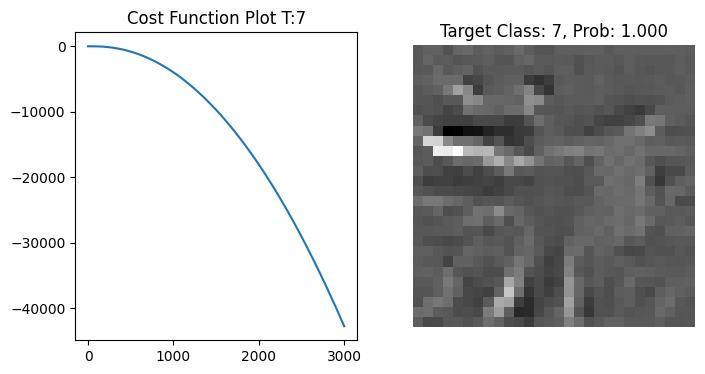

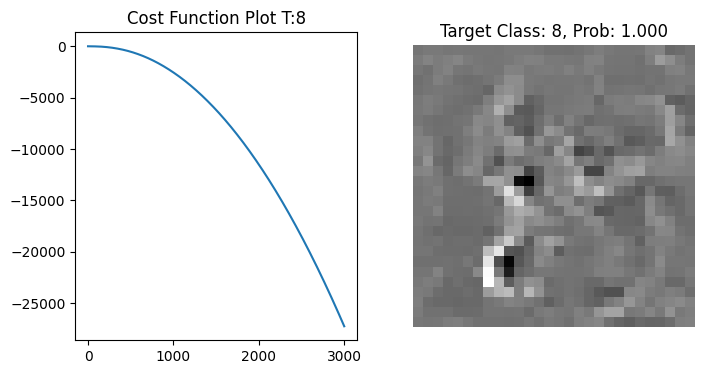

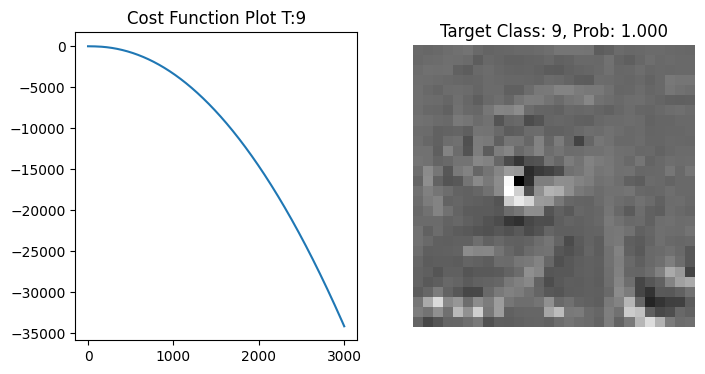

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt

for child in model.children():
    for param in child.parameters():
        param.requires_grad = False

#Initialize an empty grid to hold generated images
img_grid = np.zeros((10, 28, 28))
cost = {}

#Generate adversarial images for each target class
for i in range(10):
    #Initialize Gaussian noise
    noise = np.random.normal(loc=0.5, scale=0.05, size=(1, 1, 28, 28)).astype(np.float32)
    noise = torch.from_numpy(noise).to(device)
    x_var = noise.clone().requires_grad_(True)  # Ensure gradient tracking

    #Set up optimizer
    optimizer = torch.optim.SGD([x_var], lr=0.0001)

    #Store cost for each class
    cost[str(i)] = []

    #Optimization loop
    for j in range(3000):
        model.zero_grad()
        out_var = model(x_var)

        #Define loss as the negative output for the target class
        loss = -out_var[0][i]
        loss.backward()
        optimizer.step()

        #Store the loss value for plotting later
        cost[str(i)].append(loss.item())

    #Normalize and store the generated image
    n_img = x_var.cpu().detach().numpy()
    img_grid[i, :, :] = (n_img - n_img.min()) / (n_img.max() - n_img.min())  # Normalization

#Plotting the results
for i in range(10):
    fig = plt.figure(figsize=(8, 4))
    fig.tight_layout()
    col, row = 2, 1

    #Reshape image for model input
    in_image = torch.reshape(torch.from_numpy(img_grid[i].astype(np.float32)), (1, 1, 28, 28)).to(device)

    #Predict class and probabilities
    prediction_vect_gpu = model(in_image)
    prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()
    prediction_vect_cpu = np.squeeze(prediction_vect_cpu) - np.max(prediction_vect_cpu)  # To avoid overflow

    prediction_prob_vect = np.exp(prediction_vect_cpu) / np.sum(np.exp(prediction_vect_cpu))
    predicted_digit = np.argmax(prediction_prob_vect)
    prediction_probability = prediction_prob_vect[predicted_digit]

    #Plot the cost function
    a = fig.add_subplot(row, col, 1)
    a.title.set_text('Cost Function Plot T:{}'.format(i))
    a.plot(np.arange(0, len(cost[str(i)])), np.array(cost[str(i)]))

    #Plot the generated image and predicted probabilities
    b = fig.add_subplot(row, col, 2)
    b.title.set_text('Target Class: {}, Prob: {:.3f}'.format(predicted_digit, prediction_probability))
    plt.imshow(img_grid[i], cmap='gray')
    plt.axis('off')

plt.show()


2. Is the network always predicting targetClass with high confidence for the generated images?

<font color='green'> **Yes** </font>

3. Do the generated images look like a number? If not, can you think of some reason?

<font color='green'> **No**, Because we are generating images in accordance with how our model looks at images to classify them. So, even though the model classifys it as a digit but the image makes no sense to a human. </font>

4. Plot the cost function. Is it increasing or decreasing?

<font color='green'>  As I am increasing the probability of the classification of the digit, I am using a loss function to be negative, Since our optimizers always minimises the cost. So for my case, The cost function is **decreasing**. As per the cost function given, it would be negative of this plot i.e. 'increasing'</font>

# TARGETED ATTACK

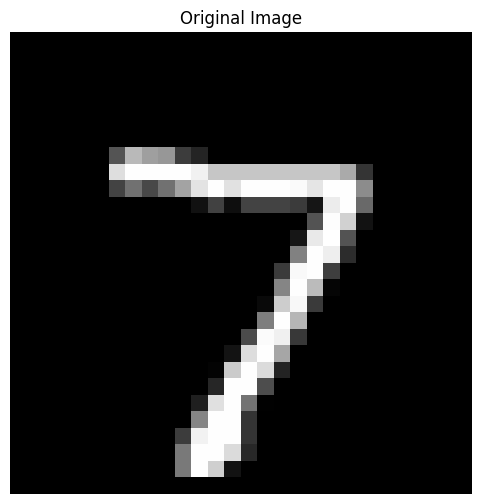

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


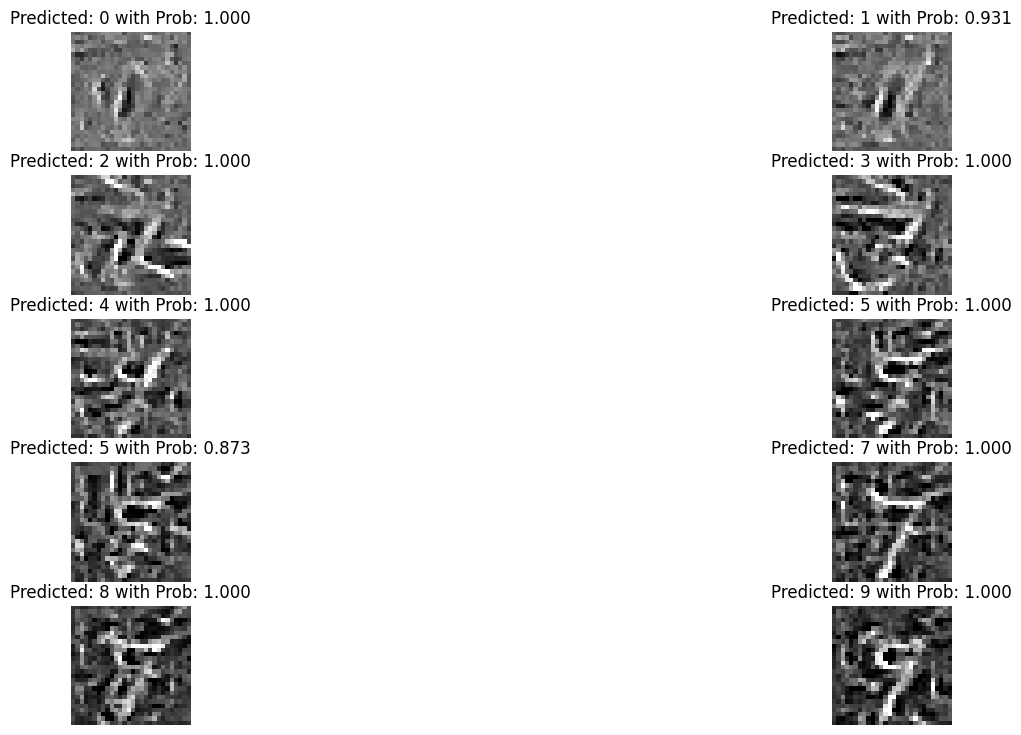

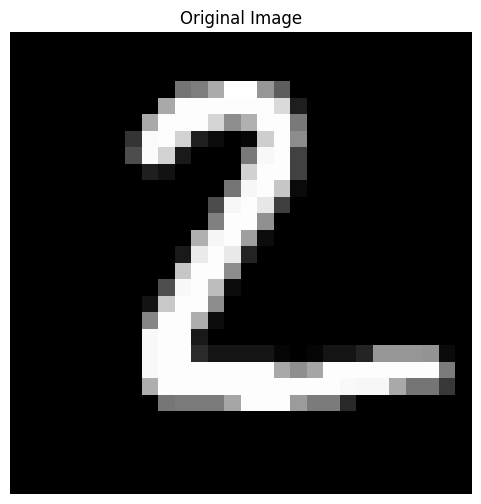

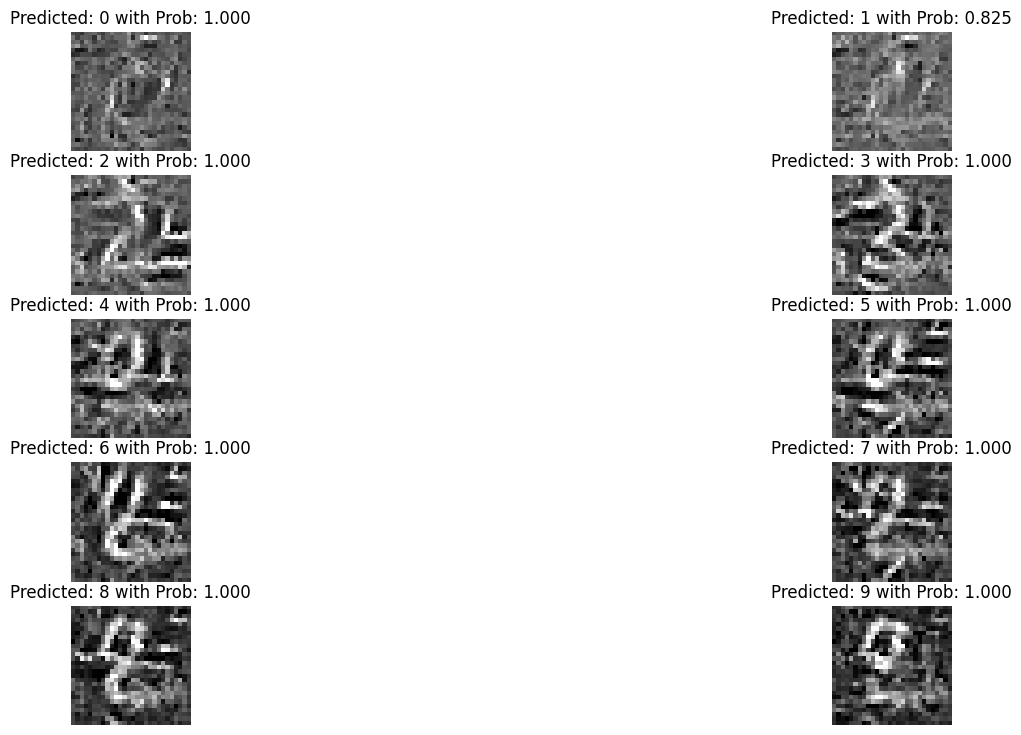

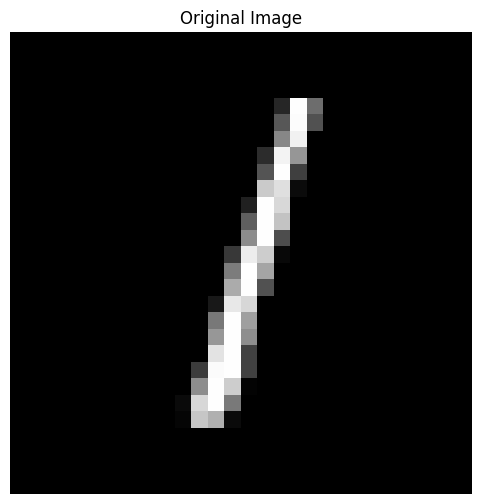

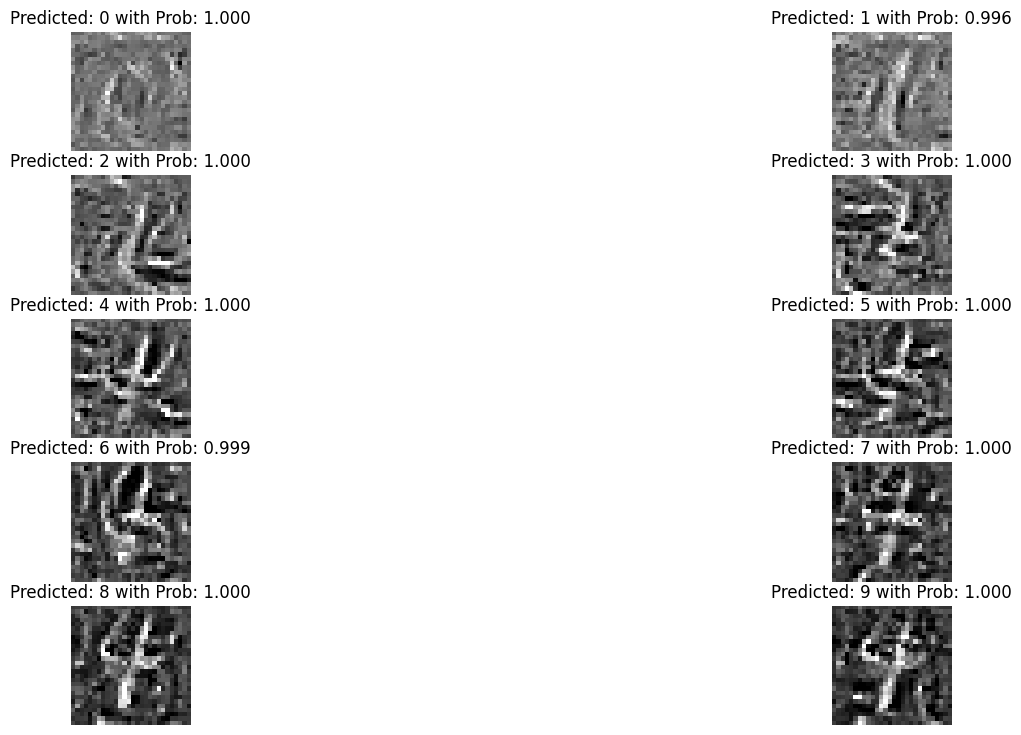

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

#Function to normalize images
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image

#Loop over batches in the test loader
for images, labels in test_loader:
    #Set a limit for the number of images to process (3 in this case)
    num_images = 3
    valid_range = min(num_images, images.size(0))  # Ensure we don't exceed batch size

    for k in range(valid_range):
        beta = 70  #Weight for MSE loss

        # Display the original target image
        target_img = images[k].to(device)
        plt.figure(figsize=(6, 6))
        plt.imshow(torch.squeeze(target_img).cpu().numpy(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        fig = plt.figure(figsize=(18, 9))
        fig.tight_layout()

        #Initialize noise image
        img_ = np.random.normal(loc=0.5, scale=0.05, size=(1, 1, 28, 28)).astype(np.float32)
        img_ = torch.from_numpy(img_).to(device).requires_grad_(True)

        #Optimizer for the adversarial image
        optimizer = torch.optim.SGD([img_], lr=0.0001)

        #Generate adversarial images for each target class
        for target_label in range(10):
            for j in range(5000):
                optimizer.zero_grad()

                #Get the model output for the adversarial image
                out_var = model(img_)

                #Define the MSE loss
                mse_loss = nn.MSELoss()

                #Compute the loss (maximize the target class score and minimize MSE)
                loss = -out_var[0][target_label] + beta * mse_loss(img_, target_img)
                loss.backward()

                #Update the image
                optimizer.step()

                #Clipping values to maintain image range
                img_.data = torch.clamp(img_.data, 0, 1)

            img_var_cpu = img_.cpu().detach().numpy()
            img_var_cpu_normalized = normalize(img_var_cpu)

            #Get prediction from the model
            prediction_vect_gpu = model(img_)
            prediction_vect_cpu = prediction_vect_gpu.detach().cpu().numpy()

            #Apply softmax to get probabilities
            prediction_prob_vect = np.exp(prediction_vect_cpu) / np.sum(np.exp(prediction_vect_cpu))

            #Identify the predicted digit and its probability
            predicted_digit = np.argmax(prediction_prob_vect)
            #Get the predicted probability for that digit
            prediction_probability = prediction_prob_vect[0][predicted_digit]  #Access the first element

            #Ensure prediction_probability is a scalar
            prediction_probability = float(prediction_probability)  #Convert to float

            #Plot the generated adversarial image
            a = fig.add_subplot(5, 2, target_label + 1)
            a.title.set_text('Predicted: {} with Prob: {:.3f}'.format(predicted_digit, prediction_probability))
            plt.imshow(np.squeeze(img_var_cpu_normalized), cmap='gray')
            plt.axis('off')

        plt.show()

    break
